# Distance Metrics and Categorical Data


- Stephen W. Thomas
- Used for MMA 869, MMAI 869, GMMA 869

How do we deal with categorical features? Standard distance metrics like Euclidean don't work. We have a number of options:

- Encode the categorical features (such as one hot encoding (i.e., dummy variables), ordinal encoding, label encoding, contrast encoding) and then using regular distance metrics
- Use a categorical-aware distance metric, like Jaccard, Dice, or Hamming
- Use a categorical-aware algorithm, like k-mediods/k-modes

In [25]:
import datetime
print(datetime.datetime.now())

2020-10-06 07:44:48.911633


In [26]:
import pandas as pd
import numpy as np
import scipy.spatial.distance as dist
import numpy as np
import itertools

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/stepthom/869_course/main/data/bank.csv")

# drop the target feature; not needed for clustering
df = df.drop(['y'], axis=1)

df.shape
df.info()
df.head(n=10)

(4521, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
dtypes: int64(7), object(9)
memory usage: 565.2+ KB


age            job  marital  education default  balance housing loan  \
0   30     unemployed  married    primary      no     1787      no   no   
1   33       services  married  secondary      no     4789     yes  yes   
2   35     management   single   tertiary      no     1350     yes   no   
3   30     management  married   tertiary      no     1476     yes  yes   
4   59    blue-collar  married  secondary      no        0     yes   no   
5   35     management   single   tertiary      no      747      no   no   
6   36  self-employed  married   tertiary      no      307     yes   no   
7   39     technician  married  secondary      no      147     yes   no   
8   41   entrepreneur  married   tertiary      no      221     yes   no   
9   43       services  married    primary      no      -88     yes  yes   

    contact  day month  duration  campaign  pdays  previous poutcome  
0  cellular   19   oct        79         1     -1         0  unknown  
1  cellular   11   may       220         1    339         4  failure  
2  cellular   16   apr       185         1    330         1  failure  
3   unknown    3   jun       199         4     -1         0  unknown  
4   unknown    5   may       226         1     -1         0  unknown  
5  cellular   23   feb       141         2    176         3  failure  
6  cellular   14   may       341         1    330         2    other  
7  cellular    6   may       151         2     -1         0  unknown  
8   unknown   14   may        57         2     -1         0  unknown  
9  cellular   17   apr       313         1    147         2  failure

In [8]:
# Descriptive stats of the numeric features
df.describe(include=[np.number]).transpose()

count         mean          std     min    25%    50%     75%  \
age       4521.0    41.170095    10.576211    19.0   33.0   39.0    49.0   
balance   4521.0  1422.657819  3009.638142 -3313.0   69.0  444.0  1480.0   
day       4521.0    15.915284     8.247667     1.0    9.0   16.0    21.0   
duration  4521.0   263.961292   259.856633     4.0  104.0  185.0   329.0   
campaign  4521.0     2.793630     3.109807     1.0    1.0    2.0     3.0   
pdays     4521.0    39.766645   100.121124    -1.0   -1.0   -1.0    -1.0   
previous  4521.0     0.542579     1.693562     0.0    0.0    0.0     0.0   

              max  
age          87.0  
balance   71188.0  
day          31.0  
duration   3025.0  
campaign     50.0  
pdays       871.0  
previous     25.0

In [9]:
# Descriptive stats of the categorical features
df.describe(include=[np.object]).transpose()

count unique         top  freq
job        4521     12  management   969
marital    4521      3     married  2797
education  4521      4   secondary  2306
default    4521      2          no  4445
housing    4521      2         yes  2559
loan       4521      2          no  3830
contact    4521      3    cellular  2896
month      4521     12         may  1398
poutcome   4521      4     unknown  3705

In [10]:
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols]
cat_cols = df.select_dtypes(include=np.object).columns
df[cat_cols]

age  balance  day  duration  campaign  pdays  previous
0      30     1787   19        79         1     -1         0
1      33     4789   11       220         1    339         4
2      35     1350   16       185         1    330         1
3      30     1476    3       199         4     -1         0
4      59        0    5       226         1     -1         0
...   ...      ...  ...       ...       ...    ...       ...
4516   33     -333   30       329         5     -1         0
4517   57    -3313    9       153         1     -1         0
4518   57      295   19       151        11     -1         0
4519   28     1137    6       129         4    211         3
4520   44     1136    3       345         2    249         7

[4521 rows x 7 columns]

job  marital  education default housing loan   contact month  \
0        unemployed  married    primary      no      no   no  cellular   oct   
1          services  married  secondary      no     yes  yes  cellular   may   
2        management   single   tertiary      no     yes   no  cellular   apr   
3        management  married   tertiary      no     yes  yes   unknown   jun   
4       blue-collar  married  secondary      no     yes   no   unknown   may   
...             ...      ...        ...     ...     ...  ...       ...   ...   
4516       services  married  secondary      no     yes   no  cellular   jul   
4517  self-employed  married   tertiary     yes     yes  yes   unknown   may   
4518     technician  married  secondary      no      no   no  cellular   aug   
4519    blue-collar  married  secondary      no      no   no  cellular   feb   
4520   entrepreneur   single   tertiary      no     yes  yes  cellular   apr   

     poutcome  
0     unknown  
1     failure  
2     failure  
3     unknown  
4     unknown  
...       ...  
4516  unknown  
4517  unknown  
4518  unknown  
4519    other  
4520    other  

[4521 rows x 9 columns]

In [11]:
from sklearn.preprocessing import StandardScaler

# Isolate all the numeric features, and scale them

X_num = df[numeric_cols].to_numpy()
X_num.shape

scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)
X_num

(4521, 7)

array([[-1.05626965,  0.12107186,  0.37405206, ..., -0.57682947,
        -0.4072183 , -0.32041282],
       [-0.77258281,  1.1186443 , -0.59602646, ..., -0.57682947,
         2.98904408,  2.04173372],
       [-0.58345826, -0.02414438,  0.01027262, ..., -0.57682947,
         2.89914302,  0.27012381],
       ...,
       [ 1.49691189, -0.37472364,  0.37405206, ...,  2.63916021,
        -0.4072183 , -0.32041282],
       [-1.24539421, -0.09492484, -1.20232553, ...,  0.38796743,
         1.71045119,  1.45119709],
       [ 0.26760226, -0.09525714, -1.56610497, ..., -0.2552305 ,
         2.09003345,  3.81334363]])

In [12]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from sklearn.preprocessing import StandardScaler
import scipy

# Here is a cool function to take an encoded version of the categorial features, along with scaled version of the numeric features and do the following:
# Appened the two sets into one 2-D array
# For a given example instance, find and print the 5 closest instances, and the 5 furthest instances
def find_closest_and_furthest(X_num, X1, example_idx=4):
    
    X_new = np.concatenate((X1, X_num), axis=1)
    
    ds = euclidean_distances(X_new, X_new)

    print('Sample instance, orig:')
    display(df.iloc[[example_idx]])
    print('Sample instance, encoded and scaled:')
    display(X_new[example_idx, :])

    indices_min = np.argsort(ds[example_idx,:])[0:5]
    indices_max = np.argsort(ds[example_idx,:])[-5:]

    print('\nThe indices of the 5 closest instances:')
    print(indices_min)

    print('\nThe distance values of of the 5 closest instances:')
    print(ds[example_idx, indices_min])

    print('\nThe 5 closest instances, orig:')
    display(df.iloc[indices_min])

    print('\nThe 5 closest instances, encoded and scaled:')
    display(X_new[indices_min, :])


    print('\nThe indices of the 5 furthest instances:')
    print(indices_max)

    print('\nThe distance values of of the 5 furthest instances:')
    print(ds[example_idx, indices_max])

    print('\nThe 5 furthest instances, orig:')
    display(df.iloc[indices_max])

    print('\nThe 5 furthest instances, encoded and scaled:')
    display(X_new[indices_max, :])

## Encoding the Categorical Features

In [13]:
from sklearn.preprocessing import OneHotEncoder

# OHE
enc = OneHotEncoder(handle_unknown='ignore')

X1 = enc.fit_transform(df[cat_cols])
X1 = X1.toarray()

find_closest_and_furthest(X_num, X1, example_idx=4)

Sample instance, orig:


age          job  marital  education default  balance housing loan  \
4   59  blue-collar  married  secondary      no        0     yes   no   

   contact  day month  duration  campaign  pdays  previous poutcome  
4  unknown    5   may       226         1     -1         0  unknown

Sample instance, encoded and scaled:


array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  1.68603644,
       -0.47275291, -1.32358535, -0.14610168, -0.57682947, -0.4072183 ,
       -0.32041282])


The indices of the 5 closest instances:
[   4  982 1392  543 3809]

The distance values of of the 5 closest instances:
[0.         0.65672971 1.03580594 1.20256255 1.23273183]

The 5 closest instances, orig:


age          job  marital  education default  balance housing loan  \
4      59  blue-collar  married  secondary      no        0     yes   no   
982    54  blue-collar  married  secondary      no     1291     yes   no   
1392   52  blue-collar  married  secondary      no      -98     yes   no   
543    48  blue-collar  married  secondary      no      157     yes   no   
3809   52  blue-collar  married  secondary      no      161     yes   no   

      contact  day month  duration  campaign  pdays  previous poutcome  
4     unknown    5   may       226         1     -1         0  unknown  
982   unknown    5   may       266         1     -1         0  unknown  
1392  unknown    7   may       423         1     -1         0  unknown  
543   unknown    6   may        73         1     -1         0  unknown  
3809  unknown   13   may       274         2     -1         0  unknown


The 5 closest instances, encoded and scaled:


array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  1.68603644,
        -0.47275291, -1.32358535, -0.14610168, -0.57682947, -0.4072183 ,
        -0.32041282],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.     


The indices of the 5 furthest instances:
[4080 3426 4397 2504 3700]

The distance values of of the 5 furthest instances:
[14.52237127 14.72463781 15.73374369 16.42585343 23.86701784]

The 5 furthest instances, orig:


age            job  marital  education default  balance housing loan  \
4080   40    blue-collar  married    primary      no     2805     yes   no   
3426   40  self-employed  married    primary      no     2077     yes   no   
4397   35    blue-collar  married  secondary      no      305     yes   no   
2504   35    blue-collar  married  secondary      no      280     yes  yes   
3700   60        retired  married    primary      no    71188      no   no   

       contact  day month  duration  campaign  pdays  previous poutcome  
4080  cellular   14   may       173         6    353        23  failure  
3426  cellular   13   may       363         1    173        24    other  
4397  cellular   18   may         7         7    367        25  failure  
2504  cellular   31   jul        65        50     -1         0  unknown  
3700  cellular    6   oct       205         1     -1         0  unknown


The 5 furthest instances, encoded and scaled:


array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        , -0.11064686,
         0.45935592, -0.23224701, -0.35008286,  1.03116537,  3.12889018,
        13.26192981],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.     

In [14]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

X2 = enc.fit_transform(df[cat_cols])
find_closest_and_furthest(X_num, X2, example_idx=4)

Sample instance, orig:


age          job  marital  education default  balance housing loan  \
4   59  blue-collar  married  secondary      no        0     yes   no   

   contact  day month  duration  campaign  pdays  previous poutcome  
4  unknown    5   may       226         1     -1         0  unknown

Sample instance, encoded and scaled:


array([ 1.        ,  1.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  2.        ,  8.        ,  3.        ,  1.68603644,
       -0.47275291, -1.32358535, -0.14610168, -0.57682947, -0.4072183 ,
       -0.32041282])


The indices of the 5 closest instances:
[   4  982 1392   26 2257]

The distance values of of the 5 closest instances:
[0.         0.65672971 1.03580594 1.09225271 1.10199267]

The 5 closest instances, orig:


age          job  marital  education default  balance housing loan  \
4      59  blue-collar  married  secondary      no        0     yes   no   
982    54  blue-collar  married  secondary      no     1291     yes   no   
1392   52  blue-collar  married  secondary      no      -98     yes   no   
26     55  blue-collar  married    primary      no      627     yes   no   
2257   55  blue-collar  married  secondary      no      383      no   no   

      contact  day month  duration  campaign  pdays  previous poutcome  
4     unknown    5   may       226         1     -1         0  unknown  
982   unknown    5   may       266         1     -1         0  unknown  
1392  unknown    7   may       423         1     -1         0  unknown  
26    unknown    5   may       247         1     -1         0  unknown  
2257  unknown    5   may       287         1     -1         0  unknown


The 5 closest instances, encoded and scaled:


array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         2.00000000e+00,  8.00000000e+00,  3.00000000e+00,
         1.68603644e+00, -4.72752908e-01, -1.32358535e+00,
        -1.46101681e-01, -5.76829470e-01, -4.07218298e-01,
        -3.20412822e-01],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         2.00000000e+00,  8.00000000e+00,  3.00000000e+00,
         1.21322505e+00, -4.37502371e-02, -1.32358535e+00,
         7.84637951e-03, -5.76829470e-01, -4.07218298e-01,
        -3.20412822e-01],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         2.00000000e+00,  8.00000000e+00,  3.00000000e+00,
         1.02410049e+00, -5.05318564e-01, -1.08106572e+00,
         6.12092516e-01, -5.76829470e-01, -4.07218298e-01,
        -3.20412822e-01],
       [ 1.00000000e+00,  1.00000000e


The indices of the 5 furthest instances:
[3426 2989 4397 2504 3700]

The distance values of of the 5 furthest instances:
[15.58252093 15.93844139 16.01719984 16.66759313 24.1998872 ]

The 5 furthest instances, orig:


age            job  marital  education default  balance housing loan  \
3426   40  self-employed  married    primary      no     2077     yes   no   
2989   42   entrepreneur  married   tertiary      no    42045      no   no   
4397   35    blue-collar  married  secondary      no      305     yes   no   
2504   35    blue-collar  married  secondary      no      280     yes  yes   
3700   60        retired  married    primary      no    71188      no   no   

       contact  day month  duration  campaign  pdays  previous poutcome  
3426  cellular   13   may       363         1    173        24    other  
2989  cellular    8   aug       205         2     -1         0  unknown  
4397  cellular   18   may         7         7    367        25  failure  
2504  cellular   31   jul        65        50     -1         0  unknown  
3700  cellular    6   oct       205         1     -1         0  unknown


The 5 furthest instances, encoded and scaled:


array([[ 6.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  8.        ,  1.        , -0.11064686,
         0.21743962, -0.35350683,  0.38117043, -0.57682947,  1.33086892,
        13.85246644],
       [ 2.        ,  1.        ,  2.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  3.        ,  0.0784777 ,
        13.49891038, -0.9598059 , -0.22692441, -0.2552305 , -0.4072183 ,
        -0.32041282],
       [ 1.        ,  1.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  8.        ,  0.        , -0.58345826,
        -0.37140061,  0.25279225, -0.98896731,  1.35276434,  3.26873628,
        14.44300308],
       [ 1.        ,  1.        ,  1.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  5.        ,  3.        , -0.58345826,
        -0.37970818,  1.82916984, -0.76574262, 15.18151997, -0.4072183 ,
        -0.32041282],
       [ 5.        ,  1.        ,  0

## Hamming, Jaccard, Dice, etc. Distance

The main idea here would be to use a "normal" distance metric on the (scaled) numeric features, and a categorical-friendly distance metric on the categocial features, and then combine the distance scores using e.g., weighted average.

Let's explore what these distances look like for a coouple of instaces, then we'll get serious with some scores.

In [15]:
from scipy.spatial import distance

def compare_instances(idx1, idx2, X1, X_num):
    np.set_printoptions(precision=2)
    print('Numeric Features of Instance {:>5}: {}'.format(idx1, X_num[idx1]))
    print('Numeric Features of Instance {:>5}: {}'.format(idx2, X_num[idx2]))
    print()
    print('Euclidean distance:   {:.2f}'.format(distance.euclidean(X_num[idx1,:], X_num[idx2,:])))
    print('Cosine distance:      {:.2f}'.format(distance.cosine(X_num[idx1,:], X_num[idx2,:])))
    print('Cityblock distance:   {:.2f}'.format(distance.cityblock(X_num[idx1,:], X_num[idx2,:])))
    print('Chebyshev distance:   {:.2f}'.format(distance.chebyshev(X_num[idx1,:], X_num[idx2,:])))
    print('Minkowski distance:   {:.2f}'.format(distance.minkowski(X_num[idx1,:], X_num[idx2,:])))
    
    print()
    print()
    print('Categorical Features of Instance {:>5}: {}'.format(idx1, X1[idx1]))
    print('Categorical Features of Instance {:>5}: {}'.format(idx2, X1[idx2]))
    print()
    print('Hamming distance:   {:.2f}'.format(distance.hamming(X1[idx1,:], X1[idx2,:])))
    print('Jaccard distance:   {:.2f}'.format(distance.jaccard(X1[idx1,:], X1[idx2,:])))


In [16]:
X1 = df[cat_cols].to_numpy()
X_new = np.concatenate((X1, X_num), axis=1)

compare_instances(0, 100, X1, X_num)

Numeric Features of Instance     0: [-1.06  0.12  0.37 -0.71 -0.58 -0.41 -0.32]
Numeric Features of Instance   100: [-0.49 -0.47 -1.2   0.28 -0.58 -0.41 -0.32]

Euclidean distance:   2.04
Cosine distance:      0.83
Cityblock distance:   3.73
Chebyshev distance:   1.58
Minkowski distance:   2.04


Categorical Features of Instance     0: ['unemployed' 'married' 'primary' 'no' 'no' 'no' 'cellular' 'oct'
 'unknown']
Categorical Features of Instance   100: ['blue-collar' 'married' 'secondary' 'no' 'yes' 'no' 'unknown' 'may'
 'unknown']

Hamming distance:   0.56
Jaccard distance:   0.56


In [17]:
compare_instances(0, 2400, X1, X_num)

Numeric Features of Instance     0: [-1.06  0.12  0.37 -0.71 -0.58 -0.41 -0.32]
Numeric Features of Instance  2400: [ 0.17 -0.44  0.13  0.26 -0.58 -0.41 -0.32]

Euclidean distance:   1.68
Cosine distance:      0.84
Cityblock distance:   3.00
Chebyshev distance:   1.23
Minkowski distance:   1.68


Categorical Features of Instance     0: ['unemployed' 'married' 'primary' 'no' 'no' 'no' 'cellular' 'oct'
 'unknown']
Categorical Features of Instance  2400: ['self-employed' 'married' 'secondary' 'no' 'no' 'no' 'unknown' 'jun'
 'unknown']

Hamming distance:   0.44
Jaccard distance:   0.44


In [18]:
compare_instances(100, 2400, X1, X_num)

Numeric Features of Instance   100: [-0.49 -0.47 -1.2   0.28 -0.58 -0.41 -0.32]
Numeric Features of Instance  2400: [ 0.17 -0.44  0.13  0.26 -0.58 -0.41 -0.32]

Euclidean distance:   1.49
Cosine distance:      0.58
Cityblock distance:   2.05
Chebyshev distance:   1.33
Minkowski distance:   1.49


Categorical Features of Instance   100: ['blue-collar' 'married' 'secondary' 'no' 'yes' 'no' 'unknown' 'may'
 'unknown']
Categorical Features of Instance  2400: ['self-employed' 'married' 'secondary' 'no' 'no' 'no' 'unknown' 'jun'
 'unknown']

Hamming distance:   0.33
Jaccard distance:   0.33


# Handle both Numeric and Catgorical Features

In [19]:
# Now, let's define our own function to handle both types of features

def custom_dist(x1, x2, cat_cols=None, num_cols=None):
   
    # First, isolate categorical features from numeric
    if cat_cols is None:
        cat_cols = [type(x)==str for x in x1]
    if num_cols is None:
        num_cols = [not x for x in cat_cols]
    
    n = len(x1)
    #print(x1)
    #print(x2)

    dist_num = distance.euclidean(x1[num_cols], x2[num_cols])
    #print(dist_num)
    dist_cat = distance.hamming(x1[cat_cols], x2[cat_cols])
    #print(dist_cat)
    
    dist = (dist_num*sum(num_cols) + dist_cat*sum(cat_cols)) / n
    #print(dist)
    return dist

In [20]:
np.set_printoptions(precision=4)

cat_cols = [type(x)==str for x in X_new[1,:]]
num_cols = [not x for x in cat_cols]

# We expect these to be pretty close
custom_dist(X_new[4,:], X_new[4,:], cat_cols, num_cols)
custom_dist(X_new[4,:], X_new[982,:], cat_cols, num_cols)
custom_dist(X_new[4,:], X_new[1392,:], cat_cols, num_cols)
custom_dist(X_new[4,:], X_new[26,:], cat_cols, num_cols)


# We expect these to be pretty far
custom_dist(X_new[4,:], X_new[3700,:], cat_cols, num_cols)
custom_dist(X_new[4,:], X_new[2504,:], cat_cols, num_cols)
custom_dist(X_new[4,:], X_new[4397,:], cat_cols, num_cols)
custom_dist(X_new[4,:], X_new[3426,:], cat_cols, num_cols)

0.0

0.28731924848145607

0.45316509767068874

0.2547094338546567

10.662260807623229

7.293457113336377

6.952673423373075

6.57206360089351

In [21]:
from scipy.spatial.distance import pdist

# Warning: pdist is kind of slow
Y = pdist(X_new[1:500,:], custom_dist, cat_cols=cat_cols, num_cols=num_cols)

In [22]:
import scipy.cluster

aggl = scipy.cluster.hierarchy.linkage(Y, method='ward')

In [23]:
aggl

array([[3.4000e+01, 4.1900e+02, 1.5057e-01, 2.0000e+00],
       [1.7000e+02, 2.7600e+02, 1.6793e-01, 2.0000e+00],
       [8.8000e+01, 4.2700e+02, 1.7109e-01, 2.0000e+00],
       ...,
       [9.7400e+02, 9.9200e+02, 1.0459e+01, 2.8200e+02],
       [9.9300e+02, 9.9400e+02, 1.1313e+01, 4.1700e+02],
       [9.9000e+02, 9.9500e+02, 1.6601e+01, 4.9900e+02]])

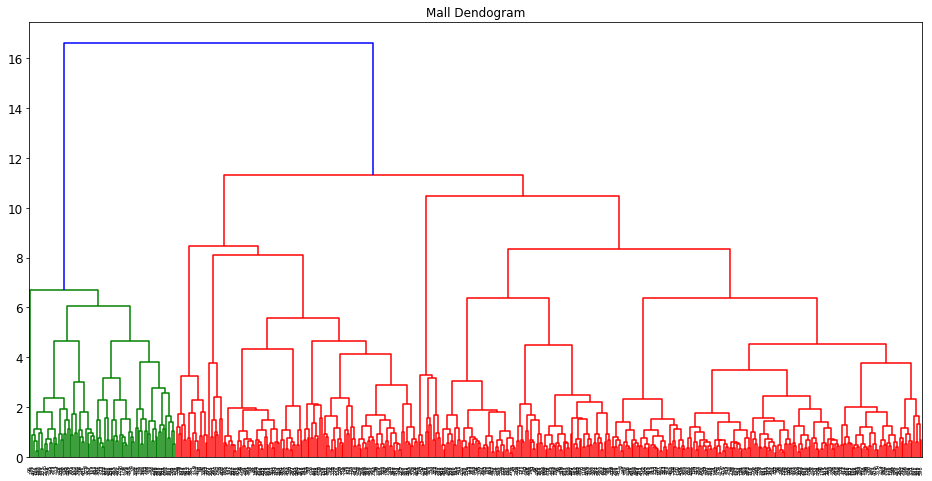

In [24]:
# Plot the dendogram 0 this time with better labels
plt.figure(figsize=(16, 8));
plt.grid(False)
plt.title("Mall Dendogram");  
dend = scipy.cluster.hierarchy.dendrogram(aggl); 